## 编程题

在CIFAR10图像数据集上练习训练深度神经网络：

CIFAR-10数据集，又称加拿大高等研究院数据集（Canadian Institute for Advanced Research）是一个常用于训练机器学习和计算机视觉算法的图像集合。它是最广泛使用的机器学习研究数据集之一。

CIFAR-10数据集包含60,000张32×32像素的彩色图像，分为10个不同的类别。这10个类别分别是飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车，每个类别有6,000张图片。

飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车 对应的分类编码是0，1，2，3，4，5，6，7，8，9


1. 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数。
2. 使用Nadam优化和早停技术，在CIFAR10数据集上训练网络。可以使用tf.keras.datasets.cifar10.load_data()加载数据。该数据集由10个类别的60000幅32×32像素的彩色图像（用于训练的50000个，用于测试的10000个）组成，因此需要一个具有10个神经元的softmax输出层。记住，每次更改模型的架构或超参数时，都要找寻正确的学习率。
3. 尝试添加批量归一化并比较学习曲线：收敛速度是否比以前快？会产生更好的模型吗？它如何影响训练速度？
4. 尝试用SELU替换批量归一化，并进行必要的调整以确保网络是自归一化的（即归一化输入特征，使用LeCun正态初始化，确保DNN仅仅包含一系列的密集层等）
5. 尝试使用Alpha dropout正则化模型。然后，在不重新训练模型的情况下，看看是否可以使用MC dropout获得更好的精度。
6. 使用1周期调度来重新训练模型，看看它是否可以提高训练速度和模型精度。

In [4]:
# 加载数据的代码
import tensorflow as tf
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
# 查看数据集形状
print("训练集图片形状:", X_train_full.shape) # 应该是 (50000, 32, 32, 3)
print("训练集标签形状:", y_train_full.shape) # 应该是 (50000, 1)

训练集图片形状: (50000, 32, 32, 3)
训练集标签形状: (50000, 1)


In [5]:
# 按0-9顺序定义类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

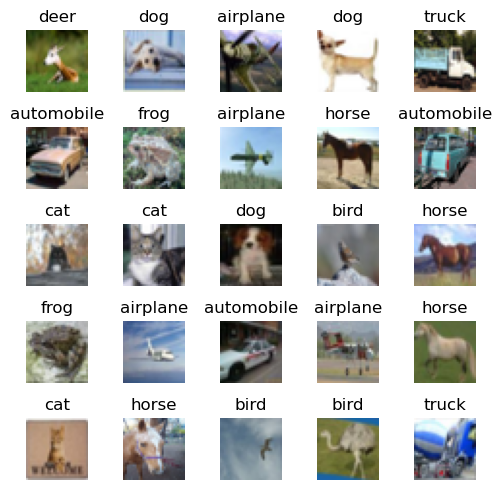

In [6]:
import numpy as np
import matplotlib.pyplot as plt

nrows = 5
ncols = 5

plt.figure(figsize=(5, 5))


random_indices = np.random.choice(len(X_train_full), nrows * ncols, replace=False)  # 无放回随机抽索引

for i, idx in enumerate(random_indices):
    plt.subplot(nrows, ncols, i+1)
    img = X_train_full[idx]
    label = y_train_full[idx, 0]
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

# 调整子图之间的间距，防止标题等重叠
plt.tight_layout()
plt.show()

In [5]:
# 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数。

model = tf.keras.models.Sequential([])
model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))

for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 activation="swish",
                                 kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [6]:
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

In [12]:
import os
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_weights.weights.h5",save_best_only=True, save_weights_only=True)
run_index = 1 # 每训练一次 run_index+=1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_{run_index:03d}")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [13]:
# tensorboard --logdir=./logs/my_cifar10_logs --port=6006

In [14]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 12s 6ms/step - loss: 1.1191 - accuracy: 0.6013 - val_loss: 1.5976 - val_accuracy: 0.4630
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.1126 - accuracy: 0.6033 - val_loss: 1.5889 - val_accuracy: 0.4780
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.1042 - accuracy: 0.6057 - val_loss: 1.5969 - val_accuracy: 0.4704
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.0976 - accuracy: 0.6085 - val_loss: 1.6038 - val_accuracy: 0.4604
Epoch 5/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.0896 - accuracy: 0.6138 - val_loss: 1.5937 - val_accuracy: 0.4710
Epoch 6/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0824 - accuracy: 0.6137 - val_loss: 1.6058 - val_accuracy: 0.4744
Epoch 7/100
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0774 - accuracy: 0.6170 - val_loss: 1.6140 - val

In [7]:
# 添加批量归一化层
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_weights.weights.h5",save_best_only=True, save_weights_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_{run_index:03d}")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 31s 13ms/step - loss: 2.0529 - accuracy: 0.2508 - val_loss: 1.9320 - val_accuracy: 0.3048
Epoch 2/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.7839 - accuracy: 0.3624 - val_loss: 1.7315 - val_accuracy: 0.3798
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6809 - accuracy: 0.4002 - val_loss: 1.7339 - val_accuracy: 0.3888
Epoch 4/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6178 - accuracy: 0.4260 - val_loss: 1.8124 - val_accuracy: 0.3576
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5592 - accuracy: 0.4483 - val_loss: 1.6880 - val_accuracy: 0.4122
Epoch 6/100
1407/1407 [==============================] - 16s 12ms/step - loss: 1.5103 - accuracy: 0.4655 - val_loss: 1.6676 - val_accuracy: 0.4148
Epoch 7/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4738 - accuracy: 0.4771 - val_loss: 1

[1.4275267124176025, 0.5145999789237976]

In [7]:
# 使用selu

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_selu_weights.weights.h5",save_best_only=True, save_weights_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_{run_index:03d}")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 16s 7ms/step - loss: 1.9356 - accuracy: 0.3052 - val_loss: 1.7789 - val_accuracy: 0.3646
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.7110 - accuracy: 0.3881 - val_loss: 1.7178 - val_accuracy: 0.3978
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6163 - accuracy: 0.4277 - val_loss: 1.6370 - val_accuracy: 0.4218
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5473 - accuracy: 0.4528 - val_loss: 1.5732 - val_accuracy: 0.4452
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.4879 - accuracy: 0.4747 - val_loss: 1.5545 - val_accuracy: 0.4566
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.4354 - accuracy: 0.4958 - val_loss: 1.5896 - val_accuracy: 0.4492
Epoch 7/100
1407/1407 [==============================] - 11s 7ms/step - loss: 1.3954 - accuracy: 0.5115 - val_loss: 1.5192 -

[1.476581335067749, 0.49000000953674316]

In [8]:
import keras.layers

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))  #
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_weights.weights.h5", save_best_only=True, save_weights_only=True)
run_index = 1
run_logdir = os.path.join(os.curdir, "my_cifar10_logs",  f"run_alpha_dropout_{run_index:03d}")
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1406/1407 [============================>.] - ETA: 0s - loss: 1.9034 - accuracy: 0.3221

D:\Downloads\anaconda3\envs\homl3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1407/1407 [==============================] - 16s 8ms/step - loss: 1.9035 - accuracy: 0.3221 - val_loss: 1.7207 - val_accuracy: 0.3866
Epoch 2/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.6831 - accuracy: 0.4040 - val_loss: 1.6611 - val_accuracy: 0.4288
Epoch 3/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5940 - accuracy: 0.4404 - val_loss: 1.6448 - val_accuracy: 0.4244
Epoch 4/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.5253 - accuracy: 0.4701 - val_loss: 1.5897 - val_accuracy: 0.4546
Epoch 5/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.4696 - accuracy: 0.4895 - val_loss: 1.5899 - val_accuracy: 0.4538
Epoch 6/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.4153 - accuracy: 0.5067 - val_loss: 1.6038 - val_accuracy: 0.4712
Epoch 7/100
1407/1407 [==============================] - 10s 7ms/step - loss: 1.3742 - accuracy: 0.5221 - val_loss: 1.6095 - val_accurac

[1.5334383249282837, 0.47859999537467957]

In [2]:
# 使用MCDropout
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

In [3]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

In [ ]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

In [ ]:
# 使用一周期调度
import math
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = tf.keras.backend.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# plot_lr_vs_loss() 函数绘制了学习率与损失的关系图。最佳学习率（可用作 1 个周期内的最大学习率）位于曲线底部附近。
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [ ]:

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
# OneCycleScheduler 自定义回调会在每个批次开始时更新学习率。
# 在训练的大约一半时间内线性增加学习率，然后线性降低回初始学习率。
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])